# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Цель исследования: Создать модель со значением метрики RMSE меньше 2500.

Ход исследования:
1. Обзор данных
2. Предобработка данных
3. Подготовка выборок
4. Обучение бустинговых моделей
5. Обучение не бустинговых моделей
6. Проверка на тестовой выборке
7. Общий вывод

## Подготовка данных

In [1]:
# устанавливаем последнюю версию scikit-learn
!pip install scikit-learn==1.3.0


# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_validate, 
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from lightgbm import LGBMRegressor

# игнорируем предупреждения
import warnings
warnings.filterwarnings("ignore")

### Обзор данных

In [2]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/autos.csv')

In [3]:
# первые строки датафрейма
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# общая информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# информация о полях
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**:
- Price — цена (евро)

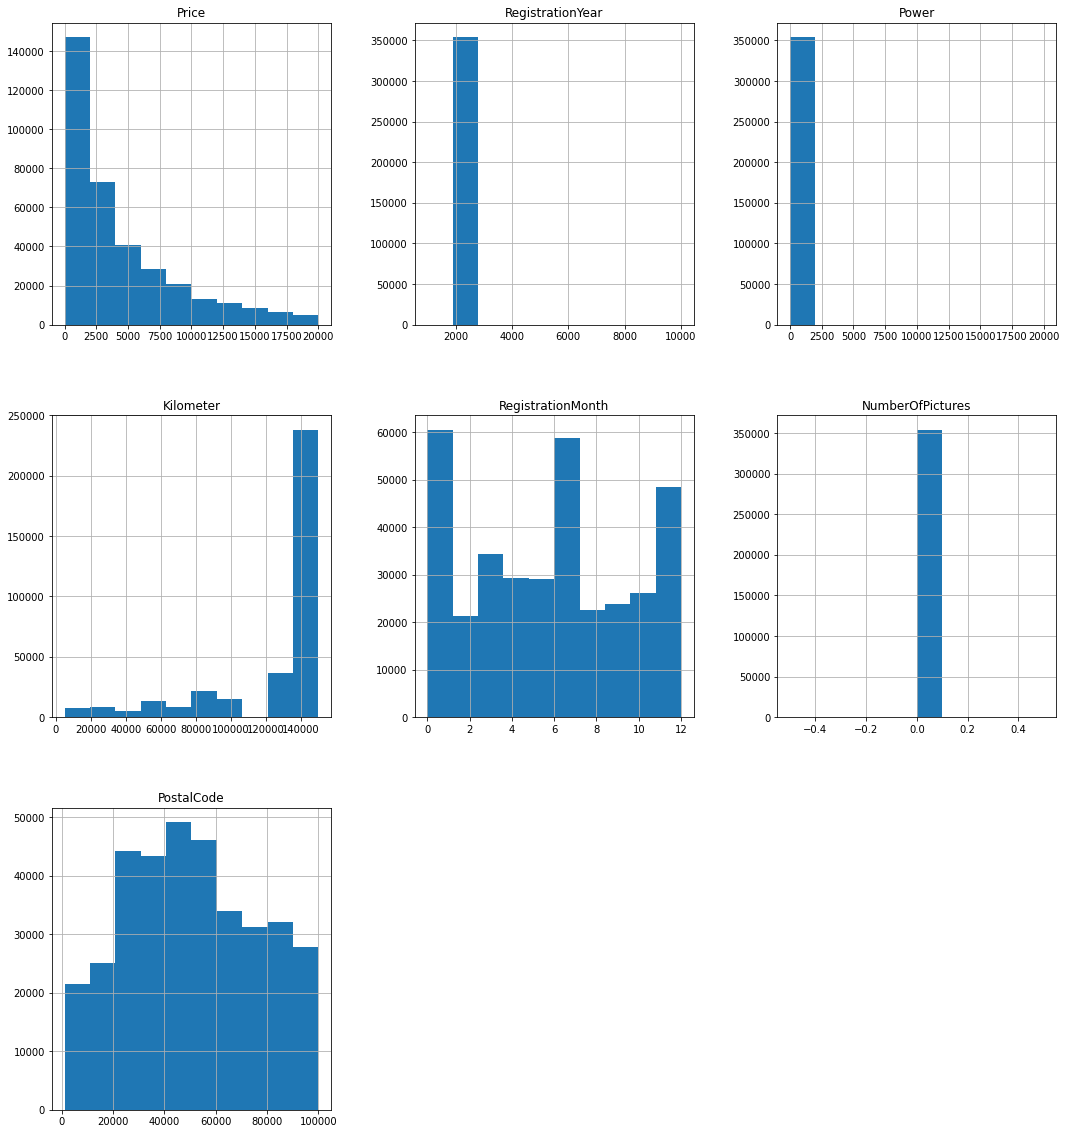

In [6]:
# распределение числовых признаков
data.hist(figsize = (18,20))
plt.show()

**Выводы:**
1. DateCrawled. Имеет тип object, но предполагает datetime. Является неинформативным признаком.
2. Price. По графику видим, что чем больше цена, тем меньше встречается объявлений. График имеет длинный хвост вправо. Имеются выбросы.
3. VehicleType. Имеет 8 уникальных значений. Самый частый тип кузова - седан. Имеются пропуски.
4. RegistrationYear. Основная масса значений находится в пределах 2000 - 2010 г. Имеются выбросы.
5. Gearbox. Принимает два значения - manual и auto. Большинство авто из анкет имеет ручную коробку передач. Имеются пропуски.
6. Power. Оснвная масса значений в пределах 69 - 143 л.с. Имеются выбросы.
7. Model. Имеет 250 уникальных значений. Самый частая модель - golf. Имеются пропуски.
8. Kilometer. Основная масса значений находится в пределах 125000 - 150000 км. График имеет длинный хвост влево. Имеются выбросы .
9. RegistrationMonth. Имеются выбросы. Является неинформативным признаком. Для успешного прогнозирования цены достаточно года регистрации автомобиля + количество строк со значением 0 чрезвычайно велико, возможно этот столбец изначально неправильно заполнялся.
10. FuelType. Имеет 7 уникальных значений. Самый частый тип топлива - petrol. Имеются пропуски.
11. Brand. Имеет 40 уникальных значений. Самый частая марка - volkswagen.
12. Repaired. Имеет 2 уникальных значений - yes и no. Большинство машин не были в ремонте. Имеются пропуски.
13. DateCreated. Имеет тип object, но предполагает datetime. Является неинформативным признаком.
14. NumberOfPictures. Во всех анкетах 0 фотографий. Является неинформативным признаком.
15. PostalCode. Является неинформативным признаком.
16. LastSeen. Имеет тип object, но предполагает datetime. Является неинформативным признаком.
17. Все названия колонок указаны в стиле CamelCase, приведем их к принятому в Python snake_case.

### Предобработка данных

#### Изменение названий столбцов

In [7]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Обработка дубликатов

In [8]:
# количество дубликатов
data.duplicated().sum()

4

Обнаружены 4 дубликата. Проверим заполненность полей в них.

In [9]:
data[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Все поля заполнены, т.е. дубликаты являются полными. Удалим их.

In [10]:
data = data.drop_duplicates().reset_index(drop=True)

Проверим наличие неявных дубликатов в категоральных признаках.

In [11]:
for i in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']:
    print(i, np.sort(data[i].astype(str).unique()), '\n')

vehicle_type ['bus' 'convertible' 'coupe' 'nan' 'other' 'sedan' 'small' 'suv' 'wagon'] 

gearbox ['auto' 'manual' 'nan'] 

model ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortw

Видим, что в столбцах `vehicle_type`, `model`, `fuel_type` присутствует значение other. Вряд ли пользователю неизвестно об этой характеристике автомобиля, скорее всего на ресурсе где владелец анкеты заполнял информацию, во всплывающем списке отсутствовали эти значения. Рассчитаем их количество.

In [12]:
for i in ['vehicle_type', 'model', 'fuel_type']:
    print(i, data[data[i]=='other'][i].count())

vehicle_type 3288
model 24420
fuel_type 204


В столбце `model` достаточно много значений `other`. Такое может быть, ведь в таблице на 40 брендов приходится всего 250 моделей машин. Остальных значений не так много. Оставим их.

В столбце `fuel_type` присутствуют значения gasoline и petrol, это означает одно и то же, в разных регионах так называют бензин. Заменим gasoline на petrol в таблице.

In [13]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')
data['fuel_type'].value_counts()

petrol      315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

#### Изменение типов данных

Столбцы `date_crawled`, `date_created` и `last_seen` имеют тип данных object. Изменим это.

In [14]:
for i in ['date_crawled', 'date_created', 'last_seen']:
    data[i] = pd.to_datetime(data[i], format='%Y-%m-%d %H:%M:%S')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

#### Обработка пропусков

In [15]:
# количество пропусков
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

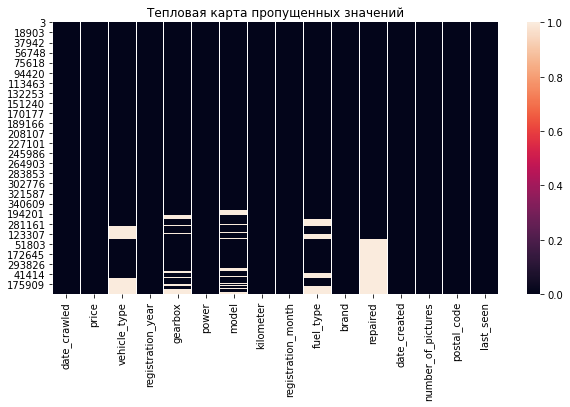

In [16]:
plt.figure(figsize=(10, 5))
sns.heatmap(data.isna().sort_values(['repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model'] ))
plt.title('Тепловая карта пропущенных значений')
plt.show()

Пропуски разбросаны по всему датасету. Какой-то системности мы не наблюдаем. Вероятность того, что ошибки технической природы минимально. Скорее всего пользователь самостоятельно не заполнил некоторые значения. Обработаем каждое поле отдельно.

**model** Предполагая, что выбор машин у создателя анкеты на сайте был ограничен и не все модели он мог внести. Делаем вывод, что пользователь мог осознано не заполнить это поле и все пропуски синонимичны значению `other`.
Заменим их.

In [17]:
data['model'] = data['model'].fillna('other')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               354365 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

**vehicle_type** Предполагаем, что пользователь не заполнил это значение указывая на то что выбранная им модель имеет только один вариант кузова, либо имеет самый встречающийся (можно сказать стандартный), либо при заполнении этого значения не было (то же самое что и other). Заполним часть этих пропусков модальными значениями типов кузова по каждой модели автомобиля, за исключением моделей `other`. Остальные заменим `other`.
Так же поступим с **fuel_type** и **gearbox**, т.к. причины пропусков могут быть аналогичны. 

Создадим функцию.

In [18]:
def mode_replace(column):
    for b in data['brand'].unique():
        for m in data[data['brand'] == b]['model'].unique():
            # берем только те модели где одна мода и модель не равна other
            if m !='other' and data.loc[(data['brand'] == b) & (data['model'] == m), column].mode().count() == 1:
                data.loc[(data['brand'] == b) & (data['model'] == m) & (data[column].isna()), column]= \
                data.loc[(data['brand'] == b) & (data['model'] == m), column].mode()[0]

    # заменяем остальные пропуска
    print('Заменяем', data[column].isna().sum(), 'значений', column, 'на other')
    data[column] = data[column].fillna('other')
    
for i in ['vehicle_type', 'fuel_type', 'gearbox']:
    mode_replace(i)
    
# количество пропусков
data.isna().sum()

Заменяем 8699 значений vehicle_type на other
Заменяем 9122 значений fuel_type на other
Заменяем 5527 значений gearbox на other


date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

**repaired** Предполагаем, что поле не заполнено т.к. ремонта не было.

In [19]:
data['repaired'] = data['repaired'].fillna('no')

# количество пропусков
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

#### Обработка аномальных значений

In [20]:
# информация о полях
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354365.0,5.714650,3.726432,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354365.0,50508.503800,25783.100078,1067.0,30165.0,49413.0,71083.0,99998.0


**registration_year** Видим аномальный минимум и максимум. Проверим максимальные даты загрузки анкеты из базы и дату последней активности пользователей.

In [21]:
print('Максимальная дата загрузки анкеты:', data['date_crawled'].max())
print('Дата последней активности пользователей', data['last_seen'].max())

Максимальная дата загрузки анкеты: 2016-04-07 14:36:58
Дата последней активности пользователей 2016-04-07 14:58:51


Последние даты установлены апрелем 2016 года. Дата регистрации авто никак не может быть позже этого времени, поэтому удалим все значения позже этого периода.

In [22]:
print('Удалим', data[~((data['registration_year'] < 2016) | ((data['registration_year'] == 2016) & (data['registration_month'] <= 4)))]['registration_year'].count(), 'строк')

data = data[(data['registration_year'] < 2016) | ((data['registration_year'] == 2016) & (data['registration_month'] <= 4))]

Удалим 19220 строк


Посмотрим на распределение годов регистрации в ХХ веке.

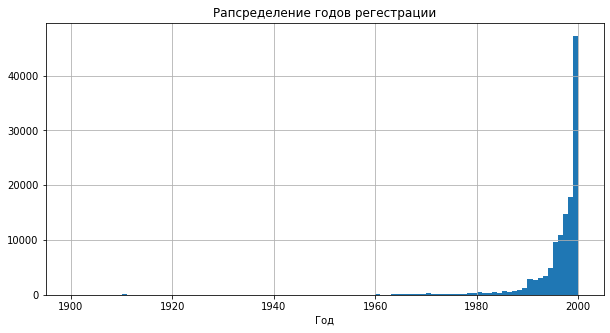

In [23]:
data['registration_year'].hist(figsize=(10,5), bins=100, range=(1900, 2000))
plt.title('Рапсределение годов регестрации')
plt.xlabel('Год')
plt.show()

Видим непрерывное появление анкет с машинами 1960 года регистрации и больше. Удалим строки с меньшими значениями.

In [24]:
print('Удалим', data[data['registration_year']<1960]['registration_year'].count(), 'строк')

data = data[data['registration_year']>=1960]

Удалим 422 строк


**price** Цена 0 евро является аномальным значением, т.к. маловероятно что какую-нибудь машину могли оценить так. Построим гистограмму и посмотрим на распределение значений цены.

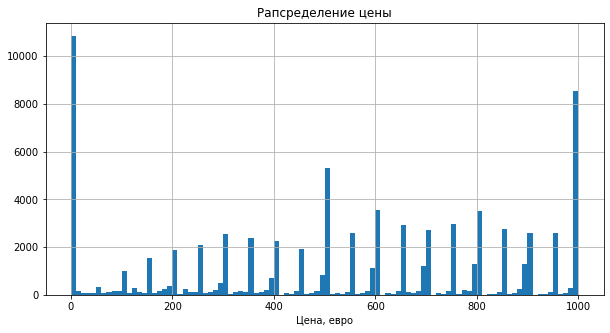

In [25]:
data['price'].hist(range=(0, 1000), bins=100, figsize=(10,5))
plt.title('Рапсределение цены')
plt.xlabel('Цена, евро')
plt.show()

Видим большое количество выбросов от 0 до 99 евро. Эти значения маловероятны и их достаточно мало, поэтому для дальнейшего исследования удалим эти строки кроме строк с ценой 0.

In [26]:
print('Удалим', data[(data['price']<100) & (data['price']!=0)]['price'].count(), 'строк')
data = data[(data['price']>=100) | (data['price']==0)]

Удалим 2372 строк


Значения с ценой 0 обработаем отдельно. Большое их количество говорит о том, что форма заполнения анкеты некорректная, т.к. пользователь в теории должен был обязательно заполнить это поле. Заполним это поле медианным значением цены по марке автомобиля, модели и году регистрации. Те строки, которые мы не смогли заменить, удалим. Создадим функцию.

In [27]:
def median_replace(column, data, df):
    for row in df.itertuples():
        if data.loc[(data['brand']==row.brand) & (data['model']==row.model) & (data['registration_year']==row.registration_year) & (data[column]!=0), column].count() != 0:
            data.loc[(data['brand']==row.brand) & (data['model']==row.model) & (data['registration_year']==row.registration_year) & (data[column]==0), column]= \
            data.loc[(data['brand']==row.brand) & (data['model']==row.model) & (data['registration_year']==row.registration_year) & (data[column]!=0), column].median()
        else:
            # Если нет совпадений по марке, модели и году, то ищем по марке и модели
            data.loc[(data['brand']==row.brand) & (data['model']==row.model) & (data['registration_year']==row.registration_year) & (data[column]==0), column] =\
            data.loc[(data['brand']==row.brand) & (data['model']==row.model) & (data[column]!=0), column].median()

    # удаляем остальные нули и пустые значения
    data[column] = data[column].replace(0, np.nan)
    print('Удалим', data[column].isna().sum(), 'строк', column)
    return data.dropna()

Создадим фрейм данных с маркой, моделью и годом регистрации при цене равной 0. И применим на ней функцию `median_replace`.

In [28]:
df_zero = data[data['price']==0][['brand', 'model', 'registration_year']].drop_duplicates()
data = median_replace('price', data, df_zero)

Удалим 0 строк price


**power** Видим аномальный минимум и максимум.

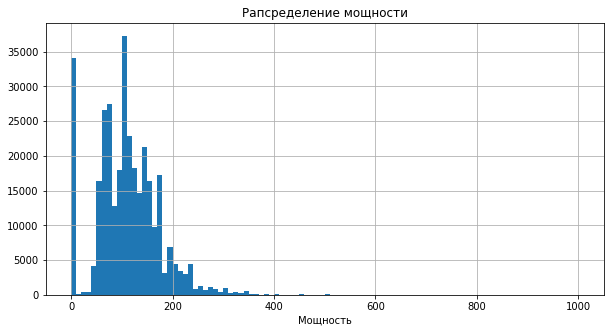

In [29]:
data['power'].hist(figsize=(10,5),bins=100, range=(0, 1000))
plt.title('Рапсределение мощности')
plt.xlabel('Мощность')
plt.show()

Анкеты с автомобилями с мощностью больше 500 л.с. почти не встречаются, удалим их.

In [30]:
print('Удалим', data[data['power']>500]['power'].count(), 'строк')

data = data[data['power'] <= 500]

Удалим 402 строк


Проверим минимум

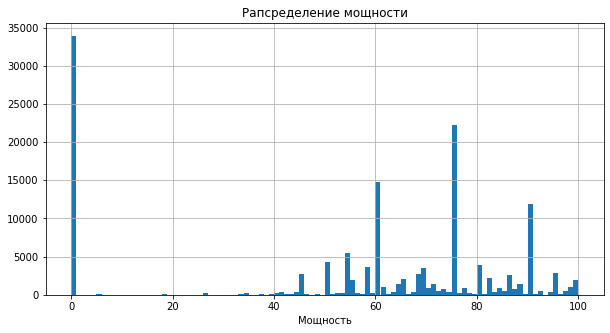

In [31]:
data['power'].hist(figsize=(10,5),bins=100, range=(0,100))
plt.title('Рапсределение мощности')
plt.xlabel('Мощность')
plt.show()

Видим что в основном встречаются анкеты с автомобилями с мощностью больше 40 л.с. остальные значения выглядят неправдоподобно. Удалим строки со значениями мощности 1 - 39.

In [32]:
print('Удалим', data[(data['power']<40) & (data['power']!=0)]['power'].count(), 'строк')
data = data[(data['power']>=40) | (data['power']==0)]

Удалим 1288 строк


Нули мы заменим медианой по аналогии с ценой с помощью функции `median_replace`.

In [33]:
df_zero = data[data['power']==0][['brand', 'model', 'registration_year']].drop_duplicates()
data = median_replace('power', data, df_zero)

Удалим 2 строк power


**registration_month** Видим значение 0 в столбце с месяцами. 

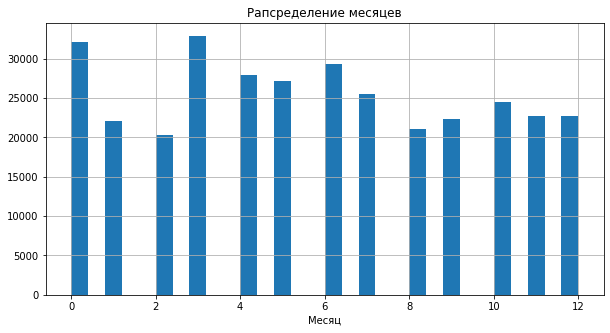

In [34]:
data['registration_month'].hist(figsize=(10,5), bins=30)
plt.title('Рапсределение месяцев')
plt.xlabel('Месяц')
plt.show()

Нулевых значений достаточно много и их заменить нельзя + этот признак обладает сомнительной информативностью, поэтому обрабатывать их не будем, а в дальнейшем удалим этот столбец.

Проверим описание полей.

In [35]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,330659.0,4611.120028,4532.625773,100.0,1200.0,2900.0,6600.0,20000.0
registration_year,330659.0,2002.438573,6.484393,1960.0,1999.0,2003.0,2007.0,2016.0
power,330659.0,119.538883,52.616074,40.0,75.0,110.0,147.0,500.0
kilometer,330659.0,128405.940864,37403.956142,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,330659.0,5.747132,3.703362,0.0,3.0,6.0,9.0,12.0
number_of_pictures,330659.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,330659.0,50687.345059,25786.102598,1067.0,30419.0,49565.0,71263.0,99998.0


Значения столбца `kilometer` находятся в пределах нормы, не будем его трогать. Столбцы `number_of_pictures` и `postal_code` удалим за их ненадобностью.

#### Удаление неинформативных признаков.

In [36]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330659 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              330659 non-null  float64
 1   vehicle_type       330659 non-null  object 
 2   registration_year  330659 non-null  int64  
 3   gearbox            330659 non-null  object 
 4   power              330659 non-null  float64
 5   model              330659 non-null  object 
 6   kilometer          330659 non-null  int64  
 7   fuel_type          330659 non-null  object 
 8   brand              330659 non-null  object 
 9   repaired           330659 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 27.8+ MB


**Вывод:** 

В результате предобработки данных мы:

1. Изменили названия столбцов
2. Удалили 4 полных дубликата строк
3. В столбце `fuel_type` заменили значение gasoline на petrol
4. В столбце `model` заменили пропуски значением other. В столбцах `fuel_type`, `vehicle_type`, `gearbox` заменили часть пропусков модальными значениями по каждой модели автомобиля. Остальные значения заменили на other
5. В столбце `repaired` заменили пропуски значением no
6. Обработали аномальные значения в столбце `registration_year` удалив их. В столбцах `price` и `power` также удалили часть аномальных значений + заменили часть 0-вых на медианные значения по марке автомобиля, модели и году регистрации
7. Удалили неинформативные признаки `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`, `last_seen`
8. Всего мы удалили 23710 строк. Что составляет 6.7%.

### Подготовка выборок

#### Разбиение данных

Данные нужно разбить на две части: обучающую и тестовую в соотношении 3:1.
- Обучающая - 75%
- Тестовая - 25%

In [38]:
features = data.drop(['price'], axis=1) 
target = data['price'] 

features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.75, random_state=96)

Проверим размеры выборок:

In [39]:
print('Размер фрейма признаков обучающей выборки:', features_train.shape)
print('Размер фрейма целевого признака обучающей выборки:', target_train.shape)
print('Размер фрейма признаков тестовой выборки:', features_test.shape)
print('Размер фрейма целевого признака тестовой выборки:', target_test.shape)

Размер фрейма признаков обучающей выборки: (247994, 9)
Размер фрейма целевого признака обучающей выборки: (247994,)
Размер фрейма признаков тестовой выборки: (82665, 9)
Размер фрейма целевого признака тестовой выборки: (82665,)


**Вывод:** В данном разделе мы произвели обзор и предобработку данных. Обозначили значение каждого поля, устранили аномалии и пропуски там где смогли. Также мы обработали дубликаты, названия и типы столбцов. В результате наших преобразований мы сохранили 93.3% исходных строк. В конце мы разделили датасет на обучающую и тестовую выборки.

## Обучение моделей

### Линейная регрессия

In [40]:
#категориальные признаки
# для модели линейной регрессии кодируем все признаки методом OHE
ohe_features_reg = features_train.select_dtypes(include='object').columns.to_list()

# численные признаки (создадим одну переменную для всех моделей)
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

# используем функцию make_column_transformer для предварительной обработки столбцов
# drop='first' удаляет первый признак из закодированных, таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore': игнорируется ранее невстречающиеся значения признака (при transform)
transformer_reg = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_reg
    ),
    (
        StandardScaler(), 
        num_features
    )
)

# создаем модель
model_reg = LinearRegression()

# передаем предварительно обработанные данные в модель машинного обучения с помощью `make_pipeline`
pipeline_reg = make_pipeline(transformer_reg, model_reg)

# используем метод кросс-валидации
cv_reg_results = cross_validate(pipeline_reg, features_train, target_train, scoring='neg_root_mean_squared_error')

In [41]:
print(f'RMSE: {cv_reg_results["test_score"].mean() * -1}')
print(f'Время обучения: {cv_reg_results["fit_time"].mean()}')
print(f'Время предсказания: {cv_reg_results["score_time"].mean()}')

RMSE: 2689.306546589739
Время обучения: 30.19529709815979
Время предсказания: 0.2570353507995605


### Случайный лес

In [42]:
#категориальные признаки
# для модели случайного леса кодируем все признаки методом OHE кроме 'model'
# т.к. большое количество столбцов повлияет на скорость обучения модели случайного леса
# 'model' будем кодировать методом OrdinalScaler
ohe_features_for = ohe_features_reg.copy()
ohe_features_for.remove('model')


# используем функцию make_column_transformer для предварительной обработки столбцов
# drop='first' удаляет первый признак из закодированных, таким образом обходим dummy-ловушку
# в OHE задаём handle_unknown='ignore': игнорируется ранее невстречающиеся значения признака (при transform)
# в OrdinalEncoder задаем handle_unknown='use_encoded_value' чтобы задать ранее невстречающиеся значения признака как -1
transformer_for = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_for
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['model']
    ),
    (
        StandardScaler(), 
        num_features
    )
)

# создаем модель
model_for = RandomForestRegressor(random_state=96)

# передаем предварительно обработанные данные в модель машинного обучения с помощью `make_pipeline`
pipeline_for = make_pipeline(transformer_for, model_for)

# сетка гиперпараметров для обучения модели
param_grid_for = {
    'randomforestregressor__n_estimators': range(10, 51, 10),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}


# используем RandomizedSearchCV т.к присутствует много параметров при переборе
# и он работает быстрее чем GridSearchCV
rs_for = RandomizedSearchCV(
    pipeline_for, 
    param_distributions=param_grid_for, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=96
)

#Обучение модели
rs_for.fit(features_train, target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['model']),
                                                                              ('standardscaler',
                                                                               StandardS...
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=96))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(2, 15),
                                        'randomforestregressor__min_samples_leaf': (1,
                                                                                    2,
                                                                                    3,
                                                                                    4),
                                        'randomforestregressor__min_samples_split': (2,
                                                                                     3,
                                                                                     4),
                                        'randomforestregressor__n_estimators': range(10, 51, 10)},
                   random_state=96, scoring='neg_root_mean_squared_error')

In [43]:
print(f'Лучший RMSE: {rs_for.best_score_ * -1}')
print(f'Лучшие параметры: {rs_for.best_params_}')
#получаем время с помощью индекса лучшего результата в массиве
print(f'Лучшее время обучения: {rs_for.cv_results_["mean_fit_time"][np.where(rs_for.cv_results_["mean_test_score"]==rs_for.best_score_)][0]}')
print(f'Лучшее время предсказания: {rs_for.cv_results_["mean_score_time"][np.where(rs_for.cv_results_["mean_test_score"]==rs_for.best_score_)][0]}')

Лучший RMSE: 1714.6282816793682
Лучшие параметры: {'randomforestregressor__n_estimators': 20, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 14}
Лучшее время обучения: 97.65611662864686
Лучшее время предсказания: 0.24478015899658204


### LightGBM

In [44]:
model_boost = LGBMRegressor(random_state=96)

# будем использовать фреймы данных 'features_train_for' и 'features_test_for' т.к.
# они закодированы нужным нам способом (OHE и OrdinalEncoder)

# передаем предварительно обработанные данные в модель машинного обучения с помощью `make_pipeline`
pipeline_boost = make_pipeline(transformer_for, model_boost)

# сетка гиперпараметров для обучения модели
param_grid_boost = {
    'lgbmregressor__max_depth': range(2, 15),
    'lgbmregressor__learning_rate': (0.1, 0.2, 0.3, 0.4)
}


# используем GridSearchCV
gs_boost = GridSearchCV(
    pipeline_boost, 
    param_grid=param_grid_boost, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
)

gs_boost.fit(features_train, target_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['model']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer'])])),
                                       ('lgbmregressor',
                                        LGBMRegressor(random_state=96))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': (0.1, 0.2, 0.3, 0.4),
                         'lgbmregressor__max_depth': range(2, 15)},
             scoring='neg_root_mean_squared_error')

In [45]:
print(f'Лучший RMSE: {gs_boost.best_score_ * -1}')
print(f'Лучшие параметры: {gs_boost.best_params_}')
#получаем время с помощью индекса лучшего результата в массиве
print(f'Лучшее время обучения: {gs_boost.cv_results_["mean_fit_time"][np.where(rs_for.cv_results_["mean_test_score"]==rs_for.best_score_)][0]}')
print(f'Лучшее время предсказания: {gs_boost.cv_results_["mean_score_time"][np.where(rs_for.cv_results_["mean_test_score"]==rs_for.best_score_)][0]}')

Лучший RMSE: 1646.5830396284043
Лучшие параметры: {'lgbmregressor__learning_rate': 0.4, 'lgbmregressor__max_depth': 14}
Лучшее время обучения: 5.0885398387908936
Лучшее время предсказания: 0.5472163200378418


**Вывод:** Лучше всех справилась модель градиентного бустинга:
- Лучший RMSE: 1646.5830396284043
- Лучшие параметры: {'lgbmregressor__learning_rate': 0.4, 'lgbmregressor__max_depth': 14}
- Лучшее время обучения: 5.0885398387908936
- Лучшее время предсказания: 0.5472163200378418

Потом идет модель случайного леса:
- Лучший RMSE: 1714.6282816793682
- Лучшие параметры: {'randomforestregressor__n_estimators': 20, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 14}
- Лучшее время обучения: 97.65611662864686
- Лучшее время предсказания: 0.24478015899658204

И хуже всех справилась модель линйеной регрессии с результатом:
- RMSE: 2689.306546589739
- Время обучения: 30.19529709815979
- Время предсказания: 0.2570353507995605

## Тест лучшей модели

Проверим модель градиентного бустинга на тестовой выборке.

In [48]:
prediction_boost = gs_boost.predict(features_test)
rmse_boost = mean_squared_error(target_test, prediction_boost, squared=False)
print(f'RMSE модели градиентного бустинга на тестовой выборке: {rmse_boost:.2f}')

RMSE модели градиентного бустинга на тестовой выборке: 1652.64


**Вывод:** Модель градиентного бустинга показывает допустимый результат на тестовой выборке. Берем эту модель в производство.

## Общий вывод

В данном проекте мы провели исследование исторических данных о продаже автомобилей, там имеется инфа о технических характеристиках, комплектации и ценах автомобилей. Нам нужно было разработать модель умеющую определть рыночную стоимость автомобиля. Заказчик - сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

В процессе исследования мы провели обзор данных в котором описали признаки.
В результате предобработки данных мы:

1. Изменили названия столбцов
2. Удалили 4 полных дубликата строк
3. В столбце `fuel_type` заменили значение gasoline на petrol
4. В столбце `model` заменили пропуски значением other. В столбцах `fuel_type`, `vehicle_type`, `gearbox` заменили часть пропусков модальными значениями по каждой модели автомобиля. Остальные значения заменили на other
5. В столбце `repaired` заменили пропуски значением no
6. Обработали аномальные значения в столбце `registration_year` удалив их. В столбцах `price` и `power` также удалили часть аномальных значений + заменили часть 0-вых на медианные значения по марке автомобиля, модели и году регистрации
7. Удалили неинформативные признаки `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`, `last_seen`
8. Всего мы удалили 23710 строк. Что составляет 6.7%.
9. Разделили таблицу на тренировочную и тестовую выборки в соотношении 3:1. 
10. Кодирование категоральных признаков:
    - Для модели линейной регрессии все категоральные признаки мы закодировали методом OHE
    - Для модели случайного леса и градиентного бустинга мы закодировали признак 'model' с помощью OrninalEncoder, остальные с помощью OHE
11. Численные признаки масштабировали с помощью StandardScaler

Мы выполнили цель и создали модель предсказывающую стоимость автомобиля со значением метрики RMSE меньше 2500. Это модель градиентного бустинга, построенная с помощью LightGBM.

- Лучший RMSE (кросс-валидация): 1646.58
- Лучший RMSE (тестовая выборка): 1652.64
- Лучшие параметры: {'lgbmregressor__learning_rate': 0.4, 'lgbmregressor__max_depth': 14}
- Лучшее время обучения: 5.0885398387908936
- Лучшее время предсказания: 0.5472163200378418

Эта модель пойдет в дальнейшее производство.

Помимо модели градиентного бустинга мы обучили и проанализировали еще 2 модели.  Но они как по качеству так и по производительности оказались хуже.
Модель случайного леса:
- Лучший RMSE: 1714.6282816793682
- Лучшие параметры: {'randomforestregressor__n_estimators': 20, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 14}
- Лучшее время обучения: 97.65611662864686
- Лучшее время предсказания: 0.24478015899658204

Линейная регрессия:
- RMSE: 2689.306546589739
- Время обучения: 30.19529709815979
- Время предсказания: 0.2570353507995605

Дальнейшие рекомендации:
- Обратить внимание на загрузку данных. В этом датасете большое количество аномалий и пропусков.
- Проверить настройки веб-формы, чтобы значения введенные пользователем проверялись.
- Модель градиентного бустинга выгодно использовать, т.к. она дает лучшие результаты при лучшей производительности.
- Для улучшения результата можно поэкспериментировать с количеством деревьев в модели градиентного бустинга. 